## Time series

The details of the code is discussed in the blog :
    
https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

### Let’s start with the Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import datetime

from sklearn.preprocessing import MinMaxScaler

import hurst

https://matplotlib.org/users/customizing.html

The dataset is from kaggle , Let's explore it 

In [2]:
data = pd.read_csv('reg_fin_df.csv')
# data = data[['Reading', 'ReadingDate']]
data.columns = ['OdoReading', 'Month']
data.head(5)

,OdoReading,Month
0,1406.0,2017-01-31
1,2049.0,2017-02-28
2,2782.0,2017-03-31
3,2858.0,2017-04-24
4,3109.0,2017-05-31


In [3]:
data.to_csv('reg_fin_df.csv', index=False)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OdoReading  51 non-null     float64
 1   Month       51 non-null     object 
dtypes: float64(1), object(1)
memory usage: 944.0+ bytes


Dataset Description 

The data contains a particular month and number of passengers travelling in that month .The data type here is object (month) Let’s convert it into a Time series object and use the Month column as our index.



Timestamps are useful objects for comparisons. You can create a timestamp object with the pd.to_datetime function and a string specifying the date. These timestamps are useful when you need to do logical filtering with dates.

In [5]:
from datetime import datetime
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-24',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-01', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-08'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [6]:
# scaler = MinMaxScaler()
# scaler.fit(data)
# data['OdoReading'] = scaler.transform(data)

In [7]:
#convert to time series:
ts = data['OdoReading']
ts.head(10)

Month
2017-01-31    1406.0
2017-02-28    2049.0
2017-03-31    2782.0
2017-04-24    2858.0
2017-05-31    3109.0
2017-06-30    3686.0
2017-07-31    4003.0
2017-08-31    4450.0
2017-09-30    4741.0
2017-10-31    5045.0
Name: OdoReading, dtype: float64

### Let’s explore the various properties of date-time based index:

In [8]:
#1. Specific the index as a string constant:
ts['2017-01-31']

1406.0

In [9]:
#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
ts[datetime(2017,1,31)]

1406.0

In [10]:
#1. Specify the entire range:
ts['2017-01-01':'2018-05-01']

Month
2017-01-31    1406.0
2017-02-28    2049.0
2017-03-31    2782.0
2017-04-24    2858.0
2017-05-31    3109.0
2017-06-30    3686.0
2017-07-31    4003.0
2017-08-31    4450.0
2017-09-30    4741.0
2017-10-31    5045.0
2017-11-30    8974.0
2017-12-31    9054.0
2018-01-31    9054.0
2018-02-01    9054.0
2018-03-31    9639.0
2018-04-30    9667.0
Name: OdoReading, dtype: float64

In [11]:
#2. Use ':' if one of the indices is at ends:
ts[:'2018-05-01']

Month
2017-01-31    1406.0
2017-02-28    2049.0
2017-03-31    2782.0
2017-04-24    2858.0
2017-05-31    3109.0
2017-06-30    3686.0
2017-07-31    4003.0
2017-08-31    4450.0
2017-09-30    4741.0
2017-10-31    5045.0
2017-11-30    8974.0
2017-12-31    9054.0
2018-01-31    9054.0
2018-02-01    9054.0
2018-03-31    9639.0
2018-04-30    9667.0
Name: OdoReading, dtype: float64

In [12]:
#All rows of 1962:
ts['2021']

Month
2021-01-31    23839.70
2021-02-28    23839.70
2021-03-08    23846.78
Name: OdoReading, dtype: float64

### STATIONARITY

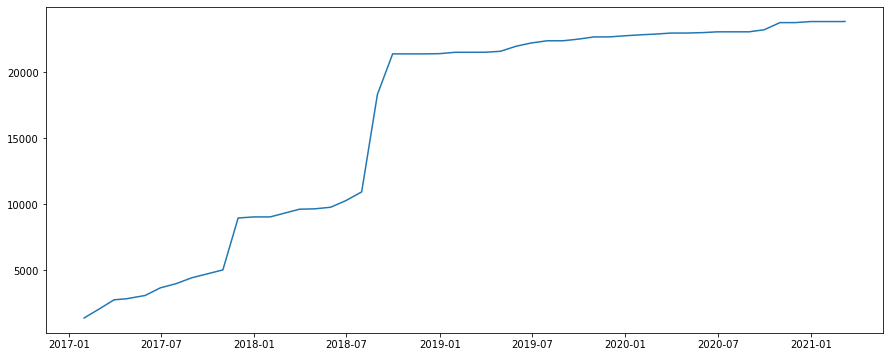

In [13]:
plt.plot(ts)

It’s clear from the plot that there is an overall increase in the trend and with some seasonality in it.

#### Stationarity testing 

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
#     rolstd = pd.rolling_std(timeseries, window=12)

    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

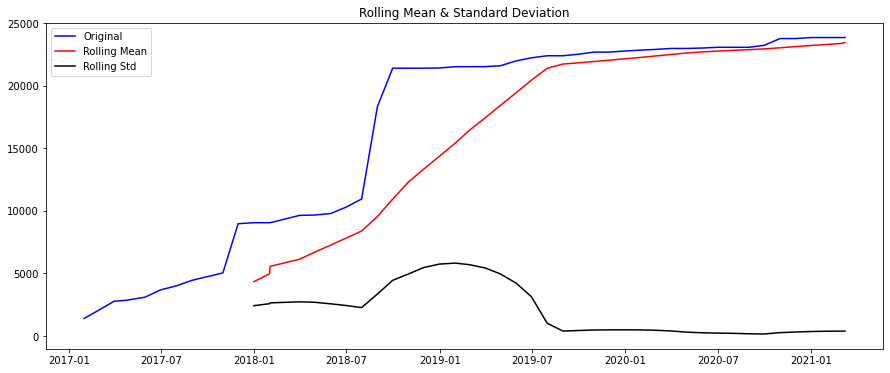

Results of Dickey-Fuller Test:
Test Statistic                 -1.671155
p-value                         0.446032
#Lags Used                      1.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


In [15]:
test_stationarity(ts)

### MAKING THE TIME SERIES STATIONARY

#### TREND 

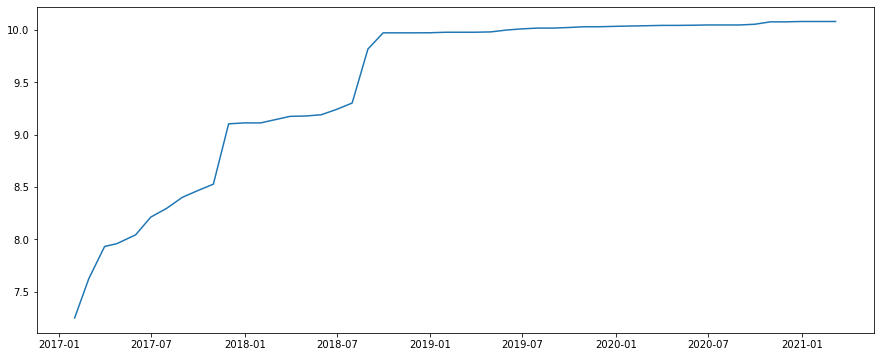

In [16]:
ts_log = np.log(ts)
plt.plot(ts_log)

##### Smoothing 

###### Moving average

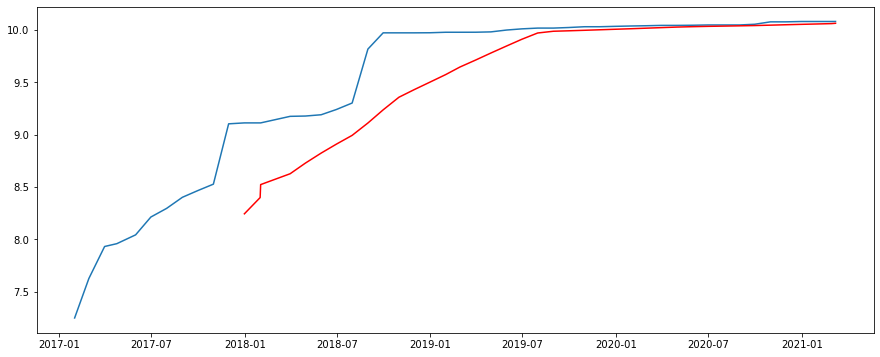

In [17]:
# moving_avg = pd.rolling_mean(ts_log,12)
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [18]:
# ts_log - moving_avg

In [19]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
2017-01-31         NaN
2017-02-28         NaN
2017-03-31         NaN
2017-04-24         NaN
2017-05-31         NaN
2017-06-30         NaN
2017-07-31         NaN
2017-08-31         NaN
2017-09-30         NaN
2017-10-31         NaN
2017-11-30         NaN
2017-12-31    0.868009
Name: OdoReading, dtype: float64

In [20]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
2017-12-31    0.868009
2018-01-31    0.712805
2018-02-01    0.588983
2018-03-31    0.548040
2018-04-30    0.449391
Name: OdoReading, dtype: float64

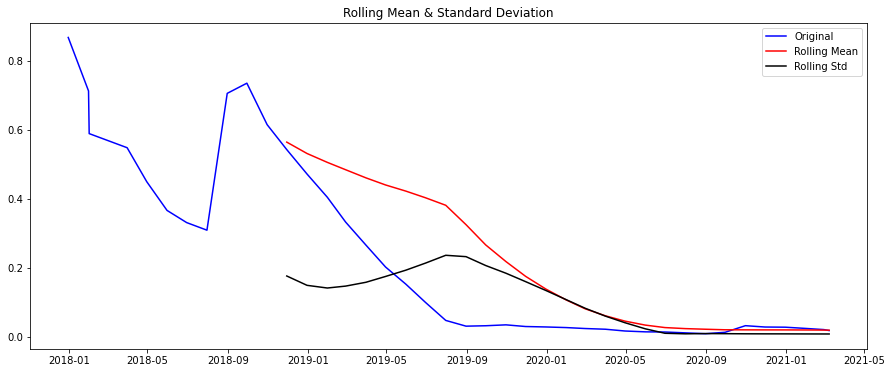

Results of Dickey-Fuller Test:
Test Statistic                 -3.781515
p-value                         0.003102
#Lags Used                     10.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [21]:
test_stationarity(ts_log_moving_avg_diff)

###### Exponentially weighted moving average

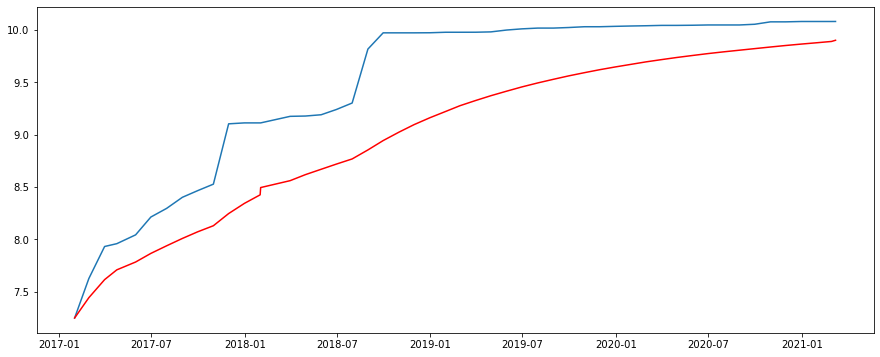

In [22]:
# expwighted_avg = pd.ewma(ts_log, halflife=12)
expwighted_avg = pd.DataFrame(ts_log).ewm(halflife=12).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')


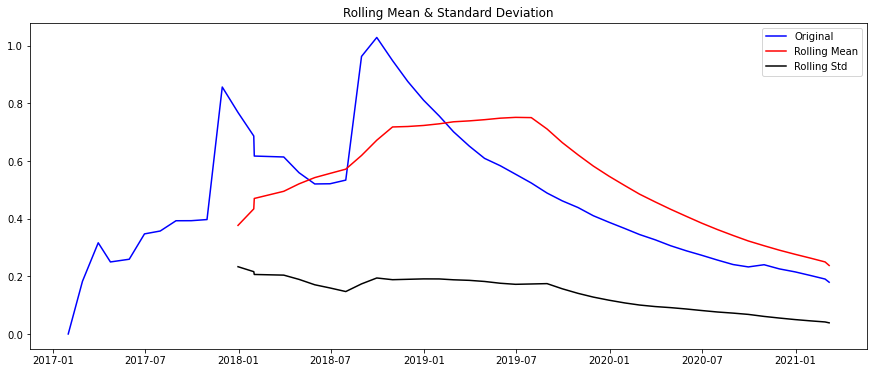

Results of Dickey-Fuller Test:
Test Statistic                 -1.481829
p-value                         0.542480
#Lags Used                      9.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [23]:
ts_log_ewma_diff = ts_log - expwighted_avg["OdoReading"]
test_stationarity(ts_log_ewma_diff)

#### SEASONALITY (ALONG WITH TREND) 

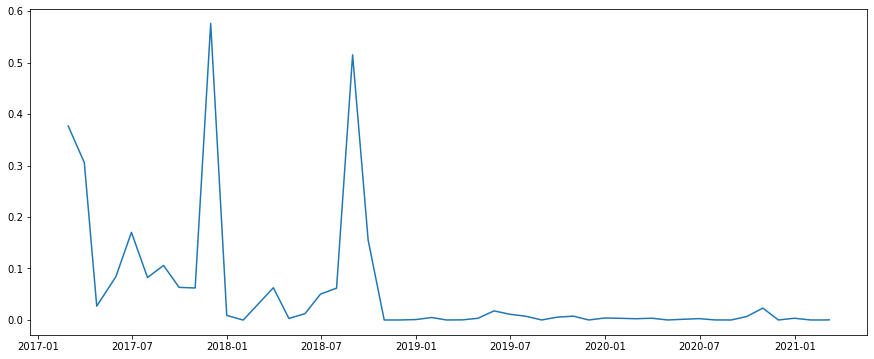

In [24]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

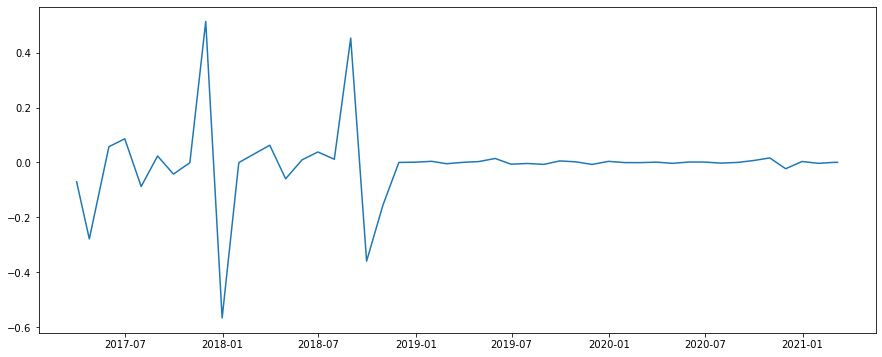

In [25]:
#Take first difference:
ts_log_diff_2od = ts_log - 2*ts_log.shift(1) + ts_log.shift(2)
plt.plot(ts_log_diff_2od)


In [26]:
ts_log_diff.isnull().sum()

1

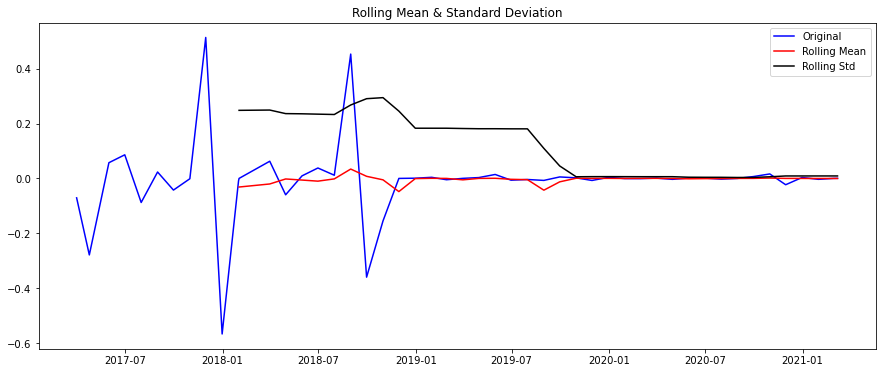

Results of Dickey-Fuller Test:
Test Statistic                 -4.643171
p-value                         0.000107
#Lags Used                      8.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In [27]:
ts_log_diff_2od = ts_log_diff_2od.dropna()
test_stationarity(ts_log_diff_2od)



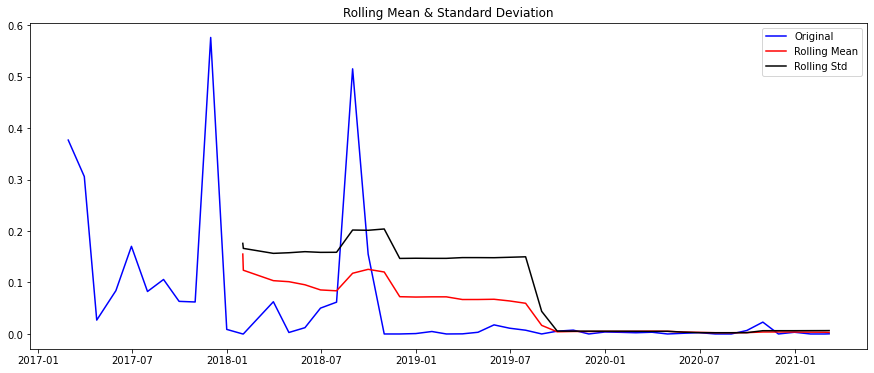

Results of Dickey-Fuller Test:
Test Statistic                 -3.039791
p-value                         0.031342
#Lags Used                      9.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In [28]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

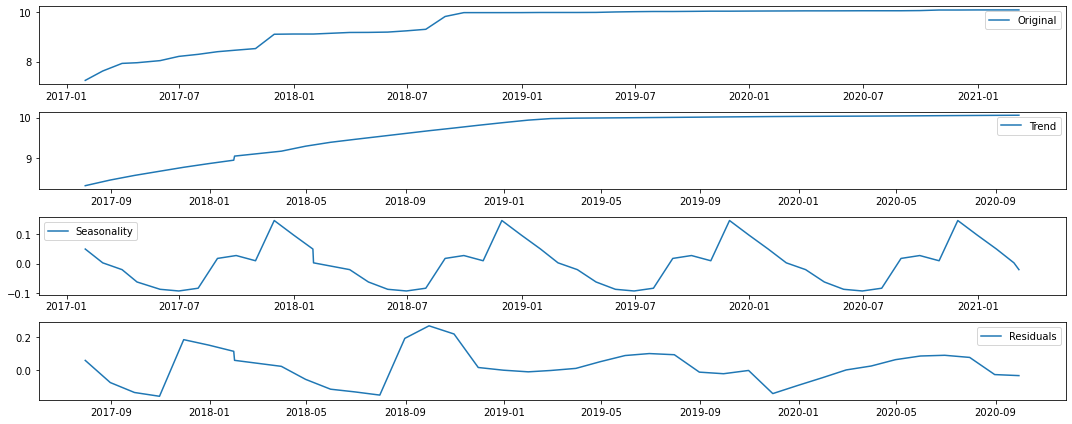

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(ts_log, freq= 12)
decomposition = seasonal_decompose(ts_log, period= 12, model='add')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

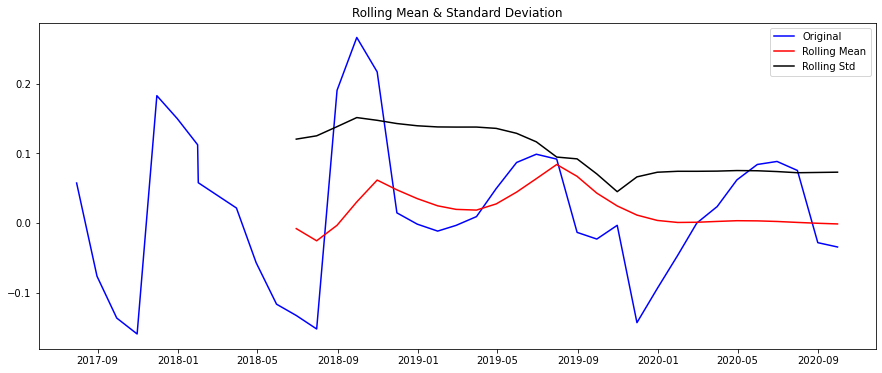

Results of Dickey-Fuller Test:
Test Statistic                 -1.878237
p-value                         0.342367
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [30]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### FORECASTING A TIME SERIES 

#### ACF & PACF  

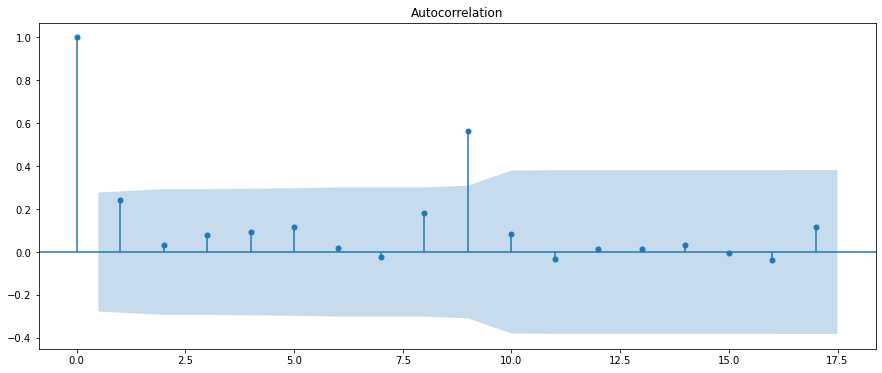

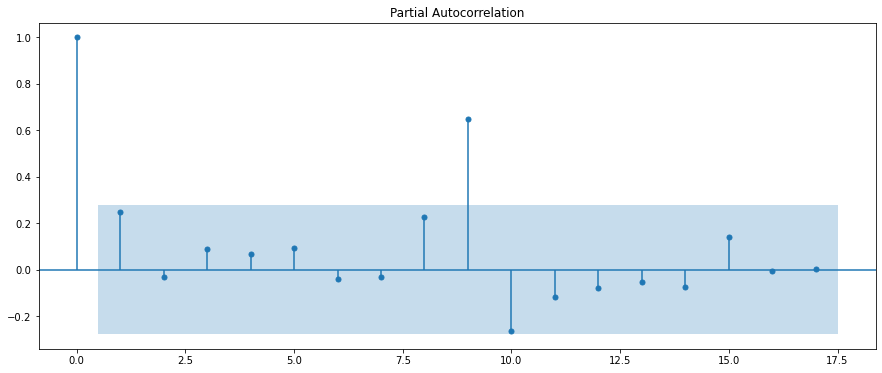

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log_diff)
plot_pacf(ts_log_diff)

plt.show()

/Users/phillemonmakamane/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


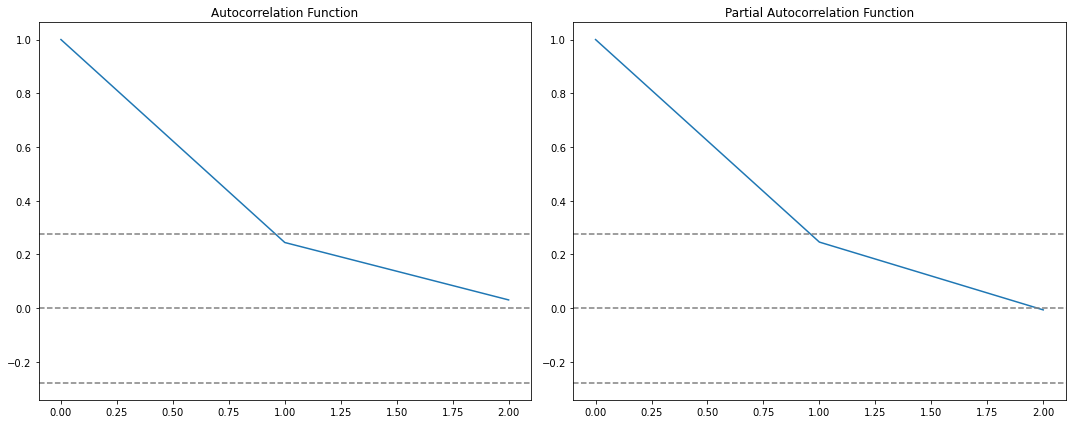

In [33]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=2)
lag_pacf = pacf(ts_log_diff, nlags=2, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [34]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

<ipython-input-34-fe7cd702419c>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [36]:
# load dataset
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')
series = ts
# series.index = series.index.to_period('M')

In [37]:
# split into train and test sets
X = series
size = int(len(X) * 0.78)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [38]:
type(ts)

pandas.core.series.Series

In [39]:
# split into train and test sets
X = series
size = int(len(X) * 0.78)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

In [40]:
print('Samples:',"\n",'Train:',len(train),"\n", 'Test:', len(test), "\n", 'ORG:', len(X))
print('Total:', len(train)+len(test))
print('Total test:', int((len(test)*100)/len(X)),'%')

Samples: 
 Train: 39 
 Test: 12 
 ORG: 51
Total: 51
Total test: 23 %


In [41]:
# walk-forward validation
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=22993.073870, expected=22970.000000
predicted=22961.468917, expected=23002.000000
predicted=23016.987905, expected=23062.000000
predicted=23078.646781, expected=23063.000000
predicted=23057.209627, expected=23063.000000
predicted=23065.144077, expected=23219.000000
predicted=23275.963194, expected=23760.000000
predicted=23939.586542, expected=23760.000000
predicted=23693.605047, expected=23839.700000
predicted=23893.687956, expected=23839.700000
predicted=23819.739175, expected=23839.700000
predicted=23847.086832, expected=23846.780000


Test RMSE: 163.134


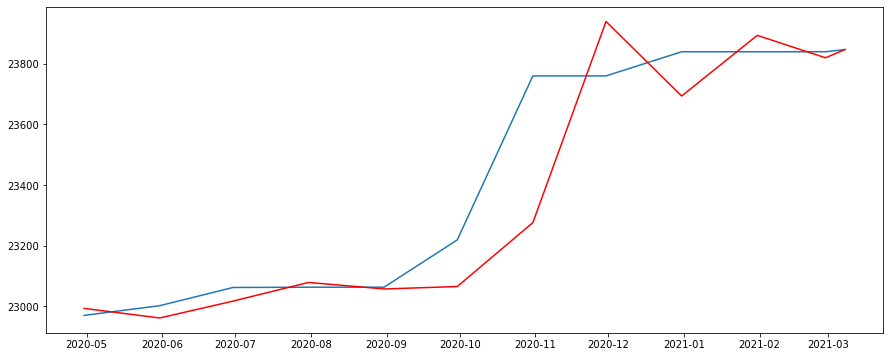

In [42]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(test.index, predictions, color='red')
pyplot.show()

In [43]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(ts.values, order=(0,1,1),seasonal_order=(1,1,2,12), 
#                 enforce_stationarity=False,
#                 enforce_invertibility=False)
# results = model.fit()
# results.summary().tables[1]

In [44]:
# results.plot_diagnostics()
# plt.show()
# '''
# The top-left plot shows the residuals over 
#     time and it appears to be a white noise with no seasonal component.
# The top-right plot shows that kde line (in red) closely follows the N(0,1)
#     line, which is the standard notation of normal distribution with zero 
#     mean and standard deviation of 1, suggesting the residuals are normally distributed.
# The bottom-left normal QQ-plot shows ordered distribution of residuals 
#     (in blue) closely follow the linear trend of the samples taken from
#     a standard normal distribution, suggesting residuals are normally distributed.
# The bottom-right is a correlogram plot indicating residuals have a low correlation with lagged versions.
# '''

In [45]:
# forecast_object.conf_int()
# forecast_object.predicted_mean

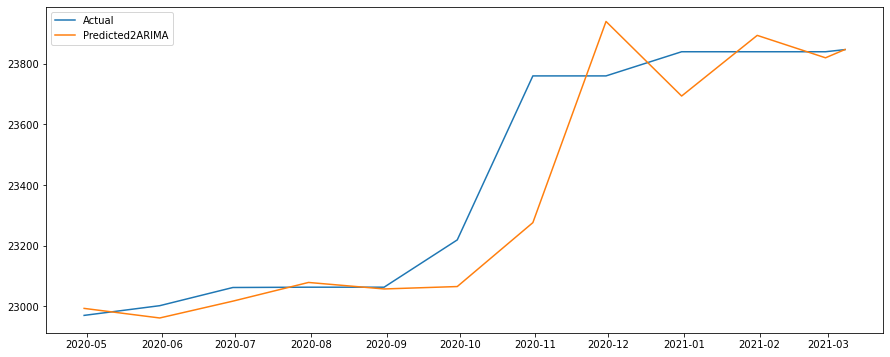

In [47]:
# forecast_object = results.get_forecast(steps=len(test))
# mean = forecast_object.predicted_mean
# conf_int = forecast_object.conf_int()
# dates = mean.index
plt.plot(test,label='Actual')
# plt.plot(test.index, mean, label='Predicted',  color='red')
plt.plot(test.index, predictions, label='Predicted2ARIMA')

plt.legend()


# pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
# pred_ci = pred.conf_int()
# ax = y['2014':].plot(label='observed')
# pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
# ax.set_xlabel('Date')
# ax.set_ylabel('Furniture Sales')
# plt.legend()
# plt.show()

In [141]:
# forecast_1= results.forecast(steps=len(test))
# pd.DataFrame(forecast_1)

In [250]:
# test

In [48]:
from sklearn.metrics import r2_score
r2=r2_score(test, predictions)

In [49]:
mean_absolute_percentage_error = np.mean(np.abs(predictions - test)/np.abs(test))*100
print('Forecast is off by {0}% and {1}% accurate'.format(
    np.round(mean_absolute_percentage_error,2), np.round(r2*100, 2)))

Forecast is off by 0.41% and 81.63% accurate


In [50]:
# type(test)

In [51]:
y_pred = []
y_true = []
forecast_errors = []
forecast_errors_abs = []

for pred, actu in zip(predictions, test):
    y_pred.append(pred)
    y_true.append(actu)
    
    forecast_errors.append(actu-pred)
    forecast_errors_abs.append(abs(actu-pred))
    

In [52]:
def model_test(expected, predicted):
    # Zero indicate no error
    # Mean Absolute Error
    from sklearn.metrics import mean_absolute_error
    MAE = mean_absolute_error(expected, predicted)
    print('MAE:', MAE)
    
    # Mean Squared Error
    from sklearn.metrics import mean_squared_error
    forecast_errors_sqr = [val**2 for val in forecast_errors]
    mse = mean_squared_error(expected, predicted)
    print('MSE:', mse)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    print('RMSE:',rmse)
    
model_test(y_true, y_pred)

MAE: 97.32366979383278
MSE: 26612.59790507845
RMSE: 163.13368108725572


In [53]:
# #------------tf-----------
# from sklearn.preprocessing import MinMaxScaler
# import math
# import tensorflow as tf

In [228]:
# ts_values = ts.values
# training_data_len = math.ceil(len(ts_values)*.8)

In [227]:
# ts_values= ts_values.reshape(-1, 1)

In [226]:
# # Scale the data to be between 0-1 A.K.A normalization  data
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(ts_values)

In [225]:
# #Create the training dataset
# #Create the scaled traing dataset
# train_data = scaled_data[0:training_data_len, :]
# #Split the data into x_train and y_train dataset
# x_train = []
# y_train = []

# for i in range(12, len(train_data)):
#     x_train.append(train_data[i-12:i,0])
#     y_train.append(train_data[i,0])
# #    if i<=61:
# #        print(x_train)
# #        print(y_train)

# #Convert the  x_train and y_train to numpy arrays
# x_train, y_train = np.array(x_train), np.array(y_train)

# #Reshape the data
# x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
# x_train.shape

In [782]:
# x_train

In [224]:
# x_train.shape[1]

In [223]:
# # Buils the LSTM model
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))

# # Compiling the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # 'mean_squared_error', 'sparse_categorical_crossentropy'
# # Train the model
# model.fit(x_train, y_train, batch_size=1, epochs=100)

In [222]:
# # create the test dataset
# #create a new array containing scaled values from index 1543 to 2003
# test_data = scaled_data[training_data_len - 12:]
# #crreate the dataset x_test and y_test
# x_test = []
# y_test = ts_values[training_data_len:]
# for i in range(12, len(test_data)):
#     x_test.append(test_data[i-12:i,0])

# # convert the data to numpy array
# x_test = np.array(x_test)
# x_test.shape

# #Reshape the data
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# # Get the model predicted price values
# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)

# # Get the root mean square error (RMSE)
# rmse =np.sqrt(np.mean(predictions - y_test)**2)
# print('Model RMSE: ', rmse)



In [213]:
# x_test.shape

In [221]:
# accScore = model.evaluate(x_test,  y_test, verbose=2)
# print("Accuracy Score: ", accScore)
# print("Model Evaluation:",model.evaluate(x_test, y_test))

In [220]:
# predictions

In [219]:
# y_test

In [218]:
# #Plot the data
# train = ts[:training_data_len]
# valid = ts[training_data_len:]
# # valid['Predictions'] = predictions

# # Visualize the data
# plt.figure(figsize=(16,8))
# plt.title('Model')
# plt.xlabel('Date', fontsize=10)
# plt.ylabel('sales', fontsize=10)
# plt.plot(scaler.inverse_transform(test_data))
# plt.plot(predictions)
# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()